In [1]:
import cv2
from matplotlib import pyplot as plt
import numpy as np

plt.rcParams['figure.figsize'] = [16, 16]

In [2]:
TEST_FILES = [
    "/Users/chris/Dev/cod_records/aws/extracted/31829_B016711/31829_B016711-00000.jpg",
    "/Users/chris/Dev/cod_records/george circumstance of death.jpg"
]

Implement this: https://stackoverflow.com/questions/46274961/removing-horizontal-lines-in-image-opencv-python-matplotlib

- Obtain binary image. Load the image, convert to grayscale, then Otsu's threshold to obtain a binary black/white image.
- Detect and remove horizontal lines. To detect horizontal lines, we create a special horizontal kernel and morph open to detect horizontal contours. From here we find contours on the mask and "fill in" the detected horizontal contours with white to effectively remove the lines
- Repair image. At this point the image may have gaps if the horizontal lines intersected through characters. To repair the text, we create a vertical kernel and morph close to reverse the damage


Also using this:
https://stackoverflow.com/a/60815631/13836535

In [3]:
def get_cmyk(bgr):
    # Make float and divide by 255 to give BGRdash
    bgrdash = bgr.astype(float)/255.

    # Calculate K as (1 - whatever is biggest out of Rdash, Gdash, Bdash)
    K = 1 - np.max(bgrdash, axis=2)
    print(K)
    # Calculate C
    C = (1-bgrdash[...,2] - K)/(1-K)

    # Calculate M
    M = (1-bgrdash[...,1] - K)/(1-K)

    # Calculate Y
    Y = (1-bgrdash[...,0] - K)/(1-K)

    # Combine 4 channels into single image and re-scale back up to uint8
    return (np.dstack((C,M,Y,K)) * 255).astype(np.uint8)

In [4]:
# Try with Y instead of K as text and lines appear different in Y, might be able to isolate
f = TEST_FILES[0]
print(f)
img = cv2.imread(f)
cmyk = get_cmyk(img)

/Users/chris/Dev/cod_records/aws/extracted/31829_B016711/31829_B016711-00000.jpg
[[0.96862745 0.96862745 0.97254902 ... 0.98039216 0.98039216 0.98039216]
 [0.97254902 0.97647059 0.98039216 ... 0.98039216 0.98039216 0.98039216]
 [0.98431373 0.98431373 0.98823529 ... 0.98039216 0.98431373 0.98431373]
 ...
 [0.99607843 0.99607843 0.99607843 ... 1.         1.         1.        ]
 [1.         1.         1.         ... 1.         1.         1.        ]
 [1.         1.         1.         ... 1.         1.         1.        ]]


/var/folders/sy/0qky3f6d6bvck117pw48s4080000gn/T/ipykernel_83114/2610979735.py:9: RuntimeWarning: invalid value encountered in divide
  C = (1-bgrdash[...,2] - K)/(1-K)
/var/folders/sy/0qky3f6d6bvck117pw48s4080000gn/T/ipykernel_83114/2610979735.py:12: RuntimeWarning: invalid value encountered in divide
  M = (1-bgrdash[...,1] - K)/(1-K)
/var/folders/sy/0qky3f6d6bvck117pw48s4080000gn/T/ipykernel_83114/2610979735.py:15: RuntimeWarning: invalid value encountered in divide
  Y = (1-bgrdash[...,0] - K)/(1-K)
/var/folders/sy/0qky3f6d6bvck117pw48s4080000gn/T/ipykernel_83114/2610979735.py:18: RuntimeWarning: invalid value encountered in cast
  return (np.dstack((C,M,Y,K)) * 255).astype(np.uint8)


Looks like divide by zero, and it is.

Better version:
https://code.adonline.id.au/cmyk-in-python/

In [5]:
def get_cmyk(bgr):
    # Create float
    bgr = img.astype(float)/255.

    # Extract channels
    with np.errstate(invalid='ignore', divide='ignore'):
        K = 1 - np.max(bgr, axis=2)
        C = (1-bgr[...,2] - K)/(1-K)
        M = (1-bgr[...,1] - K)/(1-K)
        Y = (1-bgr[...,0] - K)/(1-K)

        # Convert the input BGR image to CMYK colorspace
        CMYK = (np.dstack((C,M,Y,K)) * 255).astype(np.uint8)

    # Split CMYK channels
    # -- some adaptation here by me
    #Y, M, C, K = cv2.split(CMYK)
    channels = cv2.split(CMYK)

    for chan in channels:
        np.isfinite(chan).all()

    # return channels in unknown order! (it does not actually matter)
    return channels

/Users/chris/Dev/cod_records/aws/extracted/31829_B016711/31829_B016711-00000.jpg


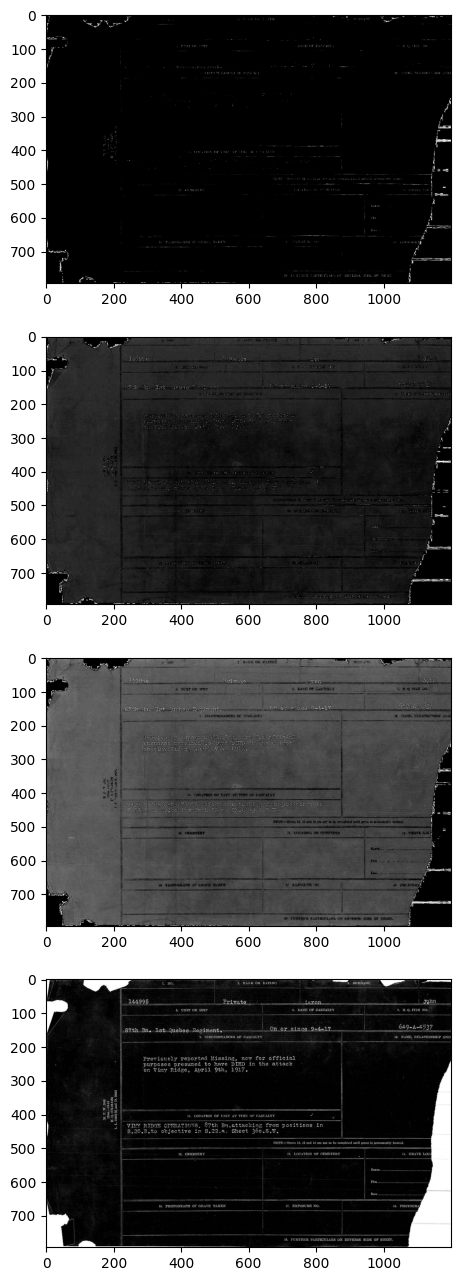

In [6]:
# Try getting all channels, this time with working function?
fig, axs = plt.subplots(4)

f = TEST_FILES[0]
print(f)
img = cv2.imread(f)

i = 0
for chan in get_cmyk(img):
    axs[i].imshow(chan, cmap='gray')
    i += 1

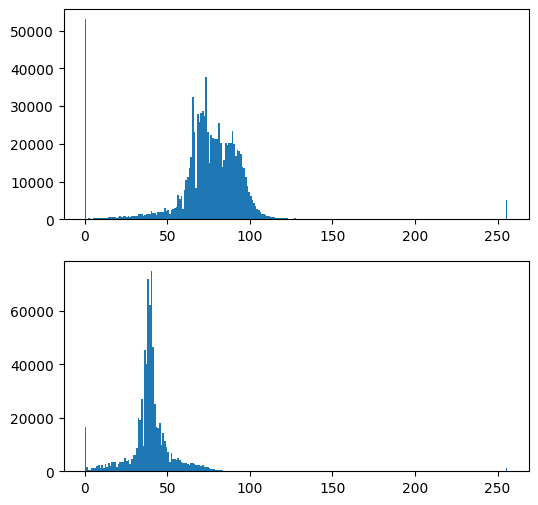

In [7]:
fig, axs = plt.subplots(2)
fig.set_size_inches(6, 6)
i = 0

for f in TEST_FILES:
    img = cv2.imread(f)
    chan2 = get_cmyk(img)[2]
    axs[i].hist(chan2.ravel(),256,[0,256])
    i += 1

In [8]:
np.median(chan2)

np.float64(39.0)

150.0
150.0


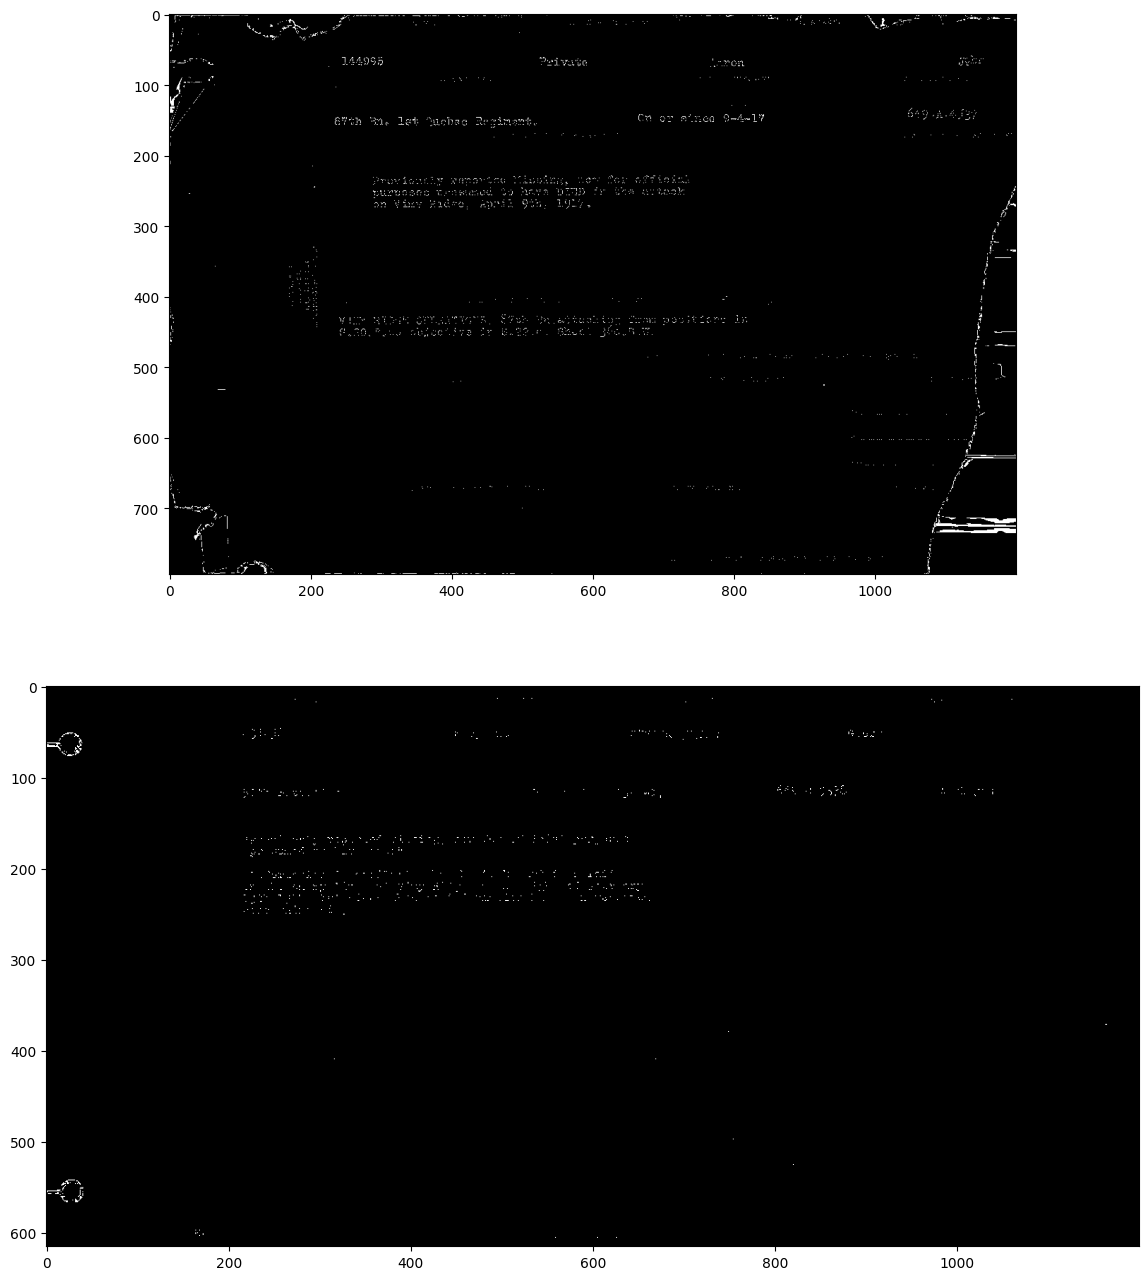

In [15]:
# apply a threshold to channel [3] which seems best contender for clarity of image
# NB suggested threshold by Otsu is 46
fig, axs = plt.subplots(2)
i = 0

for f in TEST_FILES:
    img = cv2.imread(f)
    img = cv2.fastNlMeansDenoising(img, 10, 10, 7, 21)
    chan2 = get_cmyk(img)[2]
    thresh_val, thresh = cv2.threshold(chan2, 150, 255, cv2.THRESH_BINARY)
    print(thresh_val)
    axs[i].imshow(thresh, cmap='gray')
    i += 1

95
82


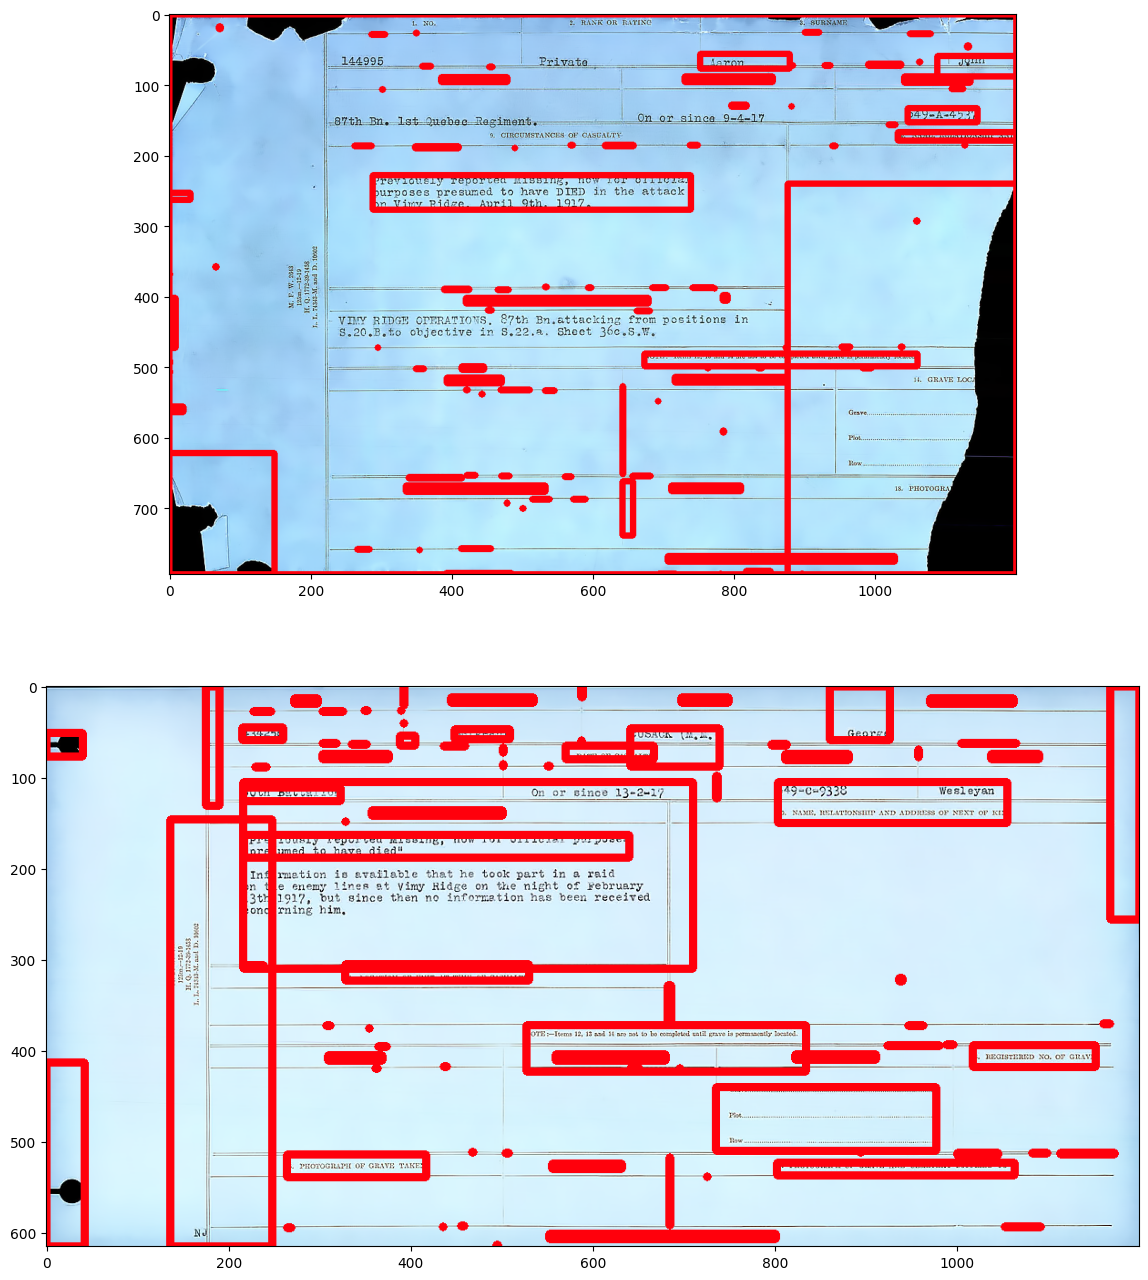

In [10]:
# To detect horizontal lines, we create a special horizontal kernel and morph open to detect horizontal contours.
# From here we find contours on the mask and "fill in" the detected horizontal contours with white to effectively remove the lines
fig, axs = plt.subplots(2)
i = 0

for f in TEST_FILES:
    img = cv2.imread(f)
    img = cv2.fastNlMeansDenoising(img, 10, 10, 7, 21)
    # reseize
    size = (img.shape[1] * 4, img.shape[0] * 4)
    #img = cv2.resize(img, size, interpolation=cv2.INTER_CUBIC)
    chan2 = get_cmyk(img)[3]
    thresh_val, thresh = cv2.threshold(chan2, 50, 255, cv2.THRESH_BINARY)
    # Remove horizontal
    horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (15,1))  # was 45,2
    detected_lines = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, horizontal_kernel, iterations=2)
    cnts = cv2.findContours(detected_lines, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]
    for c in cnts:
        cv2.drawContours(thresh, [c], -1, (0,0,0), 1)

    # Repair image
    #repair_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1,6))
    #result = 255 - cv2.morphologyEx(255 - thresh, cv2.MORPH_CLOSE, repair_kernel, iterations=1)
    eroded = cv2.erode(thresh, None, iterations=2)

    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (33,9))
    closing = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)  # was on eroded

    cnts = cv2.findContours(closing, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]
    print(len(cnts))
    skipped = 0

    rects = [cv2.boundingRect(c) for c in cnts]

    for (x,y,w,h) in rects:
        if h < 0 or h > 1000:
            skipped += 1
            continue
        cv2.rectangle(img, (x, y), (x + w, y + h), (255,0,12), 8)

    axs[i].imshow(img, cmap='gray')
    i += 1